## Importamos Librerias

In [1]:

# importamos las librerías necesarias para trabajar.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import preprocessing, svm
from sklearn.metrics import confusion_matrix, make_scorer, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

Importamos las funciones necesarias para transformar el df entrante

In [2]:
from ipynb.fs.defs.clusterai_bruno_acosta_transformations import apply_all_transformations

## Importamos los datos y los transformamos

In [3]:
df_raw = pd.read_csv("./bank_subscription (1).csv",delimiter=';',)

In [4]:
# En esta celda se define el df que se usará para el entrenamiento
df_final = apply_all_transformations(df_raw)

In [5]:
df_final

,Age,Credit,Balance (euros),Housing Loan,Personal Loan,Last Contact Day,Last Contact Duration,Campaign,Previous,Subscription,...,Last Contact Month_may,Last Contact Month_nov,Last Contact Month_oct,Last Contact Month_sep,Pdays_No Contact,Pdays_Contact Last Month,Pdays_Contact 1 to 3 Months,Pdays_Contact 3 to 6 Months,Pdays_Contact 6 to 12 Months,Pdays_Contact Over Year Ago
0,44.0,0,448.0,1,0,5,151.0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
1,28.0,0,447.0,1,1,5,217.0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
2,42.0,1,448.0,1,0,5,380.0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
3,43.0,0,593.0,1,0,5,55.0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
4,29.0,0,390.0,1,0,5,180.0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15516,23.0,0,113.0,0,0,17,266.0,1,0,1,...,0,1,0,0,1,0,0,0,0,0
15517,25.0,0,505.0,0,1,17,386.0,2,0,1,...,0,1,0,0,1,0,0,0,0,0
15518,71.0,0,1729.0,0,0,17,456.0,2,0,1,...,0,1,0,0,1,0,0,0,0,0
15519,72.0,0,5715.0,0,0,17,1127.0,5,3,1,...,0,1,0,0,0,0,0,0,1,0


## Machine Learning

Generamos los datos de training y testing

In [6]:
# Se separa el df en las variables y en la variable Y a predecir.
x = df_final.drop('Subscription',axis=1)
y = df_final['Subscription']

# Se hace el split test - train
xtrain, xtest, ytrain, ytest = train_test_split(x.values, y.values, test_size=0.2, random_state=10)

In [7]:
# Se escalan los datos, generando primero el objeto scaler en base al xtrain
scaler = preprocessing.StandardScaler().fit(xtrain)

# xtrain_scal tendra el dataset de train pre-procesado con el standard scaler
xtrain_scal = scaler.transform(xtrain)
# Utilizando el scaler "fiteado" o "ajustado" a los datos de train, aplicamos el scaler a los datos de test.
xtest_scal = scaler.transform(xtest)  

Text(0.5, 1.0, 'Standarized test data')

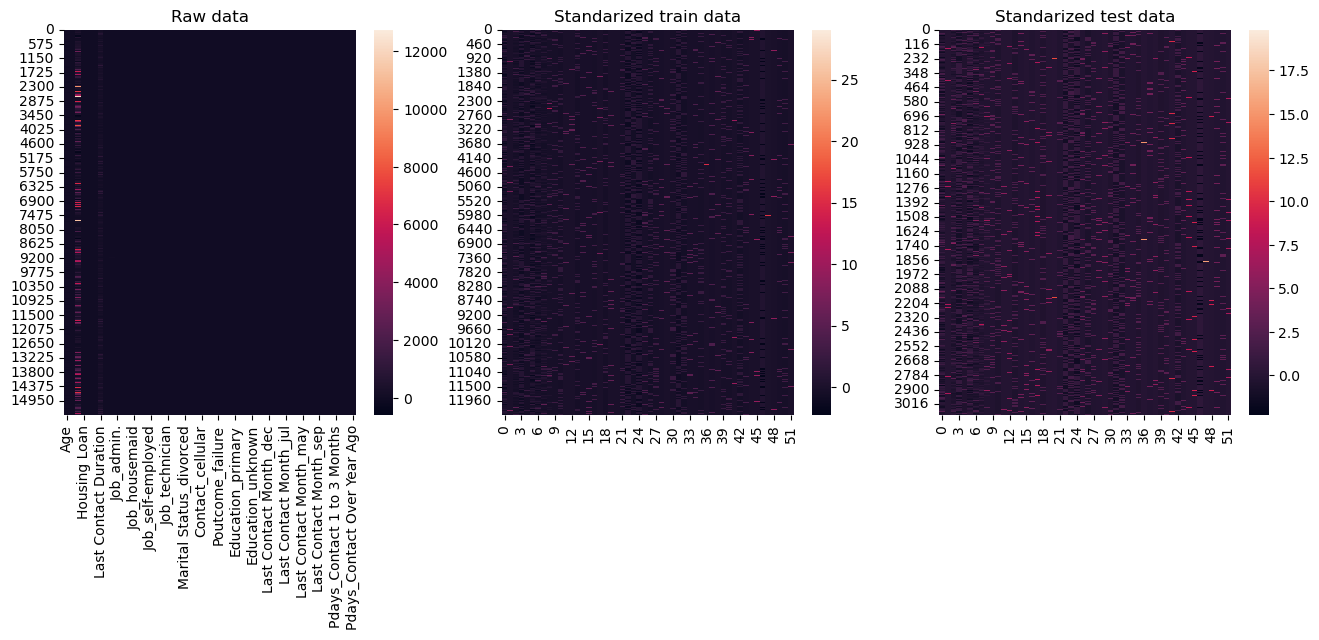

In [8]:
# Se visualiza la diferencia entre los datos crudos y los escalados
fig, axs = plt.subplots(1, 3, figsize=(16,5))
sns.heatmap(x, ax = axs[0])
sns.heatmap(xtrain_scal, ax = axs[1])
sns.heatmap(xtest_scal, ax = axs[2])
axs[0].set_title('Raw data')
axs[1].set_title('Standarized train data')
axs[2].set_title('Standarized test data')

Asumiendo que los datos fueron procesados de la mejor manera posible, ahora solo queda definir y entrenar un modelo.

Antes de comenzar, hagamos la prueba con el modelo más basico de SVC

In [9]:
# Defino el modelo
basic_svc = svm.SVC(probability=True)
# Ajusto mi modelo a las muestras de training
basic_svc.fit(xtrain_scal, ytrain)

SVC(probability=True)

In [10]:
# Genero predicciones con mi modelo entrenado para las muestras de Test, utilizando solo Xtest
ypred_basic_svc = basic_svc.predict(pd.DataFrame(xtest_scal))
basic_svc_max_roc_auc = roc_auc_score(ytest, ypred_basic_svc)
print(f'El mejor AUC ROC Score es de : {basic_svc_max_roc_auc}')

El mejor AUC ROC Score es de : 0.6352087912087911


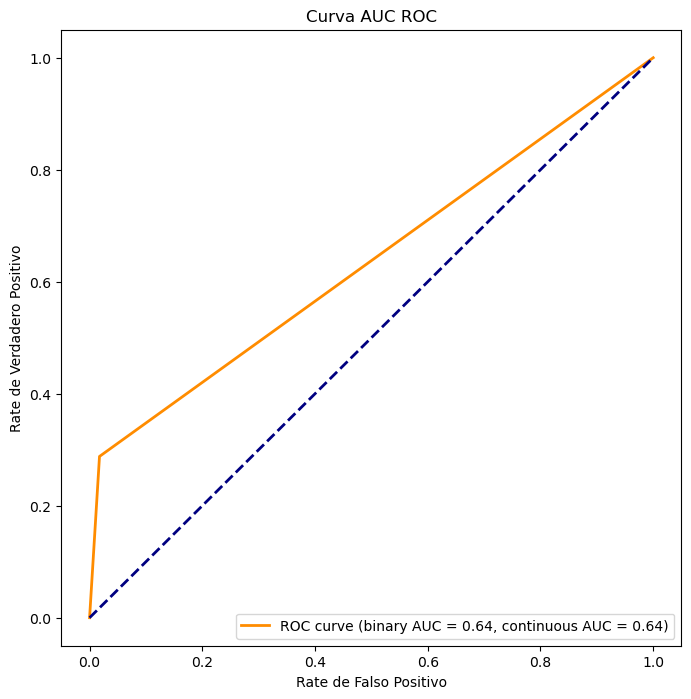

In [11]:
ypred_basic_svc_proba = basic_svc.predict(pd.DataFrame(xtest_scal))
basic_svc_roc_auc_cont = roc_auc_score(ytest, ypred_basic_svc_proba)

basic_svc_fpr, basic_svc_tpr, basic_svc_thresholds = roc_curve(ytest, ypred_basic_svc_proba)

plt.figure(figsize=(8, 8))
plt.plot(basic_svc_fpr, basic_svc_tpr, color='darkorange', lw=2, label='ROC curve (binary AUC = {:.2f}, continuous AUC = {:.2f})'.format(basic_svc_max_roc_auc, basic_svc_roc_auc_cont))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Rate de Falso Positivo')
plt.ylabel('Rate de Verdadero Positivo')
plt.title('Curva AUC ROC')
plt.legend(loc='lower right')
plt.show()

Crearemos una función para la matriz de confusión

In [12]:
def confusion(ytest, ypred, model):
    # Genero la matriz de confusión
    cm = confusion_matrix(ytest, ypred)
    
    # Se grafica la matriz
    df_cm = pd.DataFrame(cm, index = ['No Subscription', 'Subscription'], columns = ['No Subscription', 'Subscription'])
    plt.figure(figsize = (6,4))
    sns.heatmap(df_cm, annot=True, fmt=".0f")
    plt.title(f'{model} Confusion Matrix')
    plt.show()
    
    # Calculo de True Positives, True Negatives, False Positives y False Negatives
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    
    return model, sensitivity, specificity

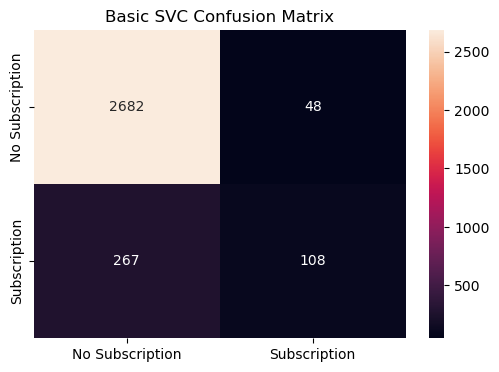

Sensitivity: 0.288
Specificity: 0.9824175824175824


In [13]:
basic_svc_data = confusion(ytest,ypred_basic_svc,'Basic SVC')

Porque los resultados son tan malos?
La resupuesta es simple: Tenemos un data set altamente desbalanceado. Esto significa que una de las clases de la variable objetivo tiene una gran mayoría sobre el data set total, como se vió en el EDA.
Para solucionarlo, es vital incluir class_weight='balanced' al definir el modelo, y se introduce la estratificación a la validación cruzada.

Comenzaremos con Linear SVC, y tomaremos este como referencia

### Linear SVC

Entrenamos el modelo, encontrando los mejores parametros con Grid Search CV

In [ ]:
# Definimos el modelo de SVC
linearsvc = svm.LinearSVC(
    max_iter=10000,
    class_weight='balanced' # class_weight en balanced es necesario, ya que el target está muy desbalanceado
    ) 

# Hyperparametros
parameters = {
    'C': [0.1, 1, 10, 100]
    }

# La estratificación garantiza que en cada uno de los folds que se haga, la proporción de clases se mantenga similar al original
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
    ) # Se define una sola vez, se vuelve a usar para proximos GSCV

# Hacemos la busqueda de los mejores parámetros
linearsvc_cv = GridSearchCV(linearsvc, # modelo
                   param_grid = parameters, # Hyperparametros
                   refit = True, # refit nos devuelve el modelo con los mejores parametros encontrados 
                   cv = skf, # cv indica la cantidad de folds
                   verbose = 0,
                   scoring = 'roc_auc', # Métrica por la cual se evalua
                   n_jobs = -1 # Usar todos los procesadores mientras se entrena el modelo
                   )

# Ajusto mi modelo a las muestras de training
linearsvc_cv.fit(xtrain_scal, ytrain)

In [57]:
best_params = linearsvc_cv.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 1}


In [15]:
# Genero predicciones con mi modelo entrenado para las muestras de Test, utilizando solo Xtest
ypred_linsvc = linearsvc_cv.predict(pd.DataFrame(xtest_scal))
lin_max_roc_auc = roc_auc_score(ytest, ypred_linsvc)
print(f'El mejor AUC ROC Score es de : {lin_max_roc_auc}')

El mejor AUC ROC Score es de : 0.8279633699633698


Ahora, grafiquemos la curva AUC ROC y la matriz de confusión

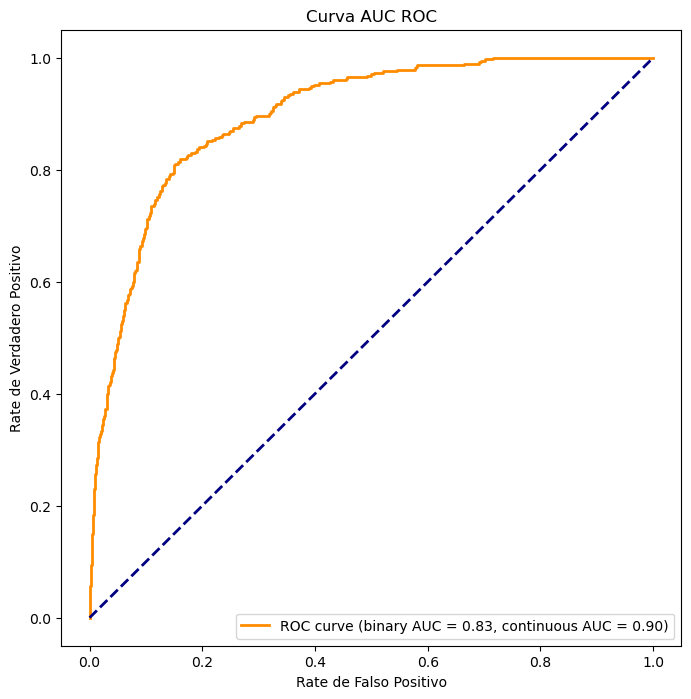

In [16]:
# Obtenemos las probabilidades en vez del resultado
ypred_linsvc_proba = linearsvc_cv.decision_function(pd.DataFrame(xtest_scal))
lin_roc_auc_cont = roc_auc_score(ytest, ypred_linsvc_proba)

# Obtenemos los valores necesarios para graficar la curva
linsvc_fpr, linsvc_tpr, linsvc_thresholds = roc_curve(ytest, ypred_linsvc_proba)

# Graficamos la curva AUC ROC
plt.figure(figsize=(8, 8))
plt.plot(linsvc_fpr, linsvc_tpr, color='darkorange', lw=2, label='ROC curve (binary AUC = {:.2f}, continuous AUC = {:.2f})'.format(lin_max_roc_auc, lin_roc_auc_cont))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Rate de Falso Positivo')
plt.ylabel('Rate de Verdadero Positivo')
plt.title('Curva AUC ROC')
plt.legend(loc='lower right')
plt.show()

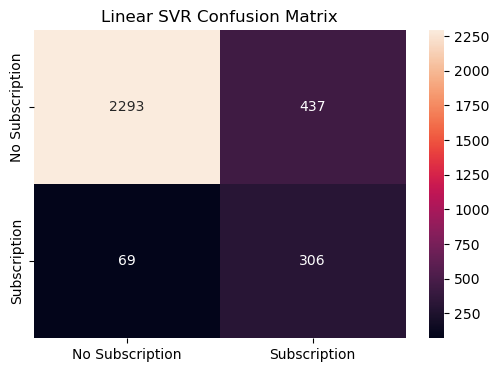

Sensitivity: 0.816
Specificity: 0.8399267399267399


In [17]:
linear_svr_data = confusion(ytest, ypred_linsvc, 'Linear SVR')

Se puede ver un primer buen resultado, con un AUC ROC score mayor al 80%

Probaremos unos modelos más y definiremos cual es el mejor, empezando con SVC normal

### KNN

In [ ]:
# Definimos el modelo KNN
knn = KNeighborsClassifier()

# Hyperparametros de KNN a explorar
parameters = {
    'n_neighbors': [2, 3, 5, 7, 10, 20, 30],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': [10, 30, 50, 100],
    'metric': ['euclidean', 'manhattan']
}

# Establecemos el scorer
scorer = make_scorer(roc_auc_score)

# Generamos el gridsearch con el modelo, los hyperparametros y el scorer
knn_cv = GridSearchCV(
    knn,
    param_grid=parameters,
    refit=True,
    cv=skf,
    verbose=0,
    scoring=scorer,
    n_jobs=-1
)

# Ajustamos el modelo
knn_cv.fit(xtrain_scal, ytrain)

In [56]:
# Imprimimos los mejores parametros
best_params_knn = knn_cv.best_params_
print("Best Parameters for KNN:", best_params_knn)

Best Parameters for KNN: {'leaf_size': 10, 'metric': 'euclidean', 'n_neighbors': 2, 'p': 1, 'weights': 'distance'}


In [19]:
# Genero predicciones con mi modelo entrenado para las muestras de Test, utilizando solo Xtest
ypred_knn_cv = knn_cv.predict(pd.DataFrame(xtest_scal))
knn_max_roc_auc = roc_auc_score(ytest, ypred_knn_cv)
print(f'El mejor AUC ROC Score es de : {knn_max_roc_auc}')

El mejor AUC ROC Score es de : 0.6759487179487179


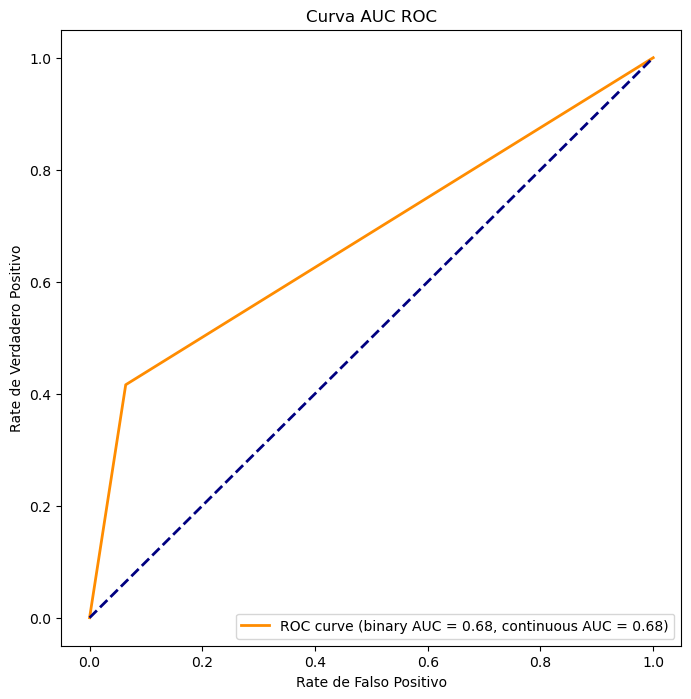

In [20]:
ypred_knn_proba = knn_cv.predict(pd.DataFrame(xtest_scal))
knn_roc_auc_cont = roc_auc_score(ytest, ypred_knn_proba)

knn_fpr, knn_tpr, knn_thresholds = roc_curve(ytest, ypred_knn_proba)

plt.figure(figsize=(8, 8))
plt.plot(knn_fpr, knn_tpr, color='darkorange', lw=2, label='ROC curve (binary AUC = {:.2f}, continuous AUC = {:.2f})'.format(knn_max_roc_auc, knn_roc_auc_cont))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Rate de Falso Positivo')
plt.ylabel('Rate de Verdadero Positivo')
plt.title('Curva AUC ROC')
plt.legend(loc='lower right')
plt.show()

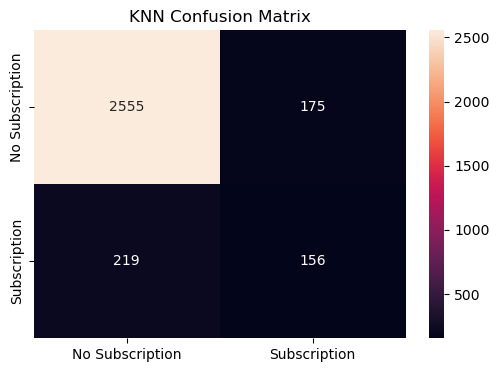

Sensitivity: 0.416
Specificity: 0.9358974358974359


In [21]:
knn_data = confusion(ytest, ypred_knn_cv, 'KNN')

### SVC

In [ ]:
svc = svm.SVC(
    class_weight='balanced',
    probability=True, # Probability automaticamente guarda las probabilides ademas del resultado 0 - 1
    max_iter=10000
    )

parameters = {
    'gamma': [0.01, 0.1, 1, 10],
    'C': [0.1, 1, 10],
    'kernel' : ['rbf','linear','poly','sigmoid']
    }

svc_cv = GridSearchCV(
    svc,
    param_grid = parameters,
    refit = True,
    cv = skf,
    verbose = 0,
    scoring = 'roc_auc',
    n_jobs = -1
)

svc_cv.fit(xtrain_scal, ytrain)

In [55]:
best_params = svc_cv.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


In [23]:
ypred_svc_cv = svc_cv.predict(pd.DataFrame(xtest_scal))
svc_max_roc_auc = roc_auc_score(ytest, ypred_svc_cv)
print(f'El mejor AUC ROC Score es de : {svc_max_roc_auc}')

El mejor AUC ROC Score es de : 0.8305787545787545


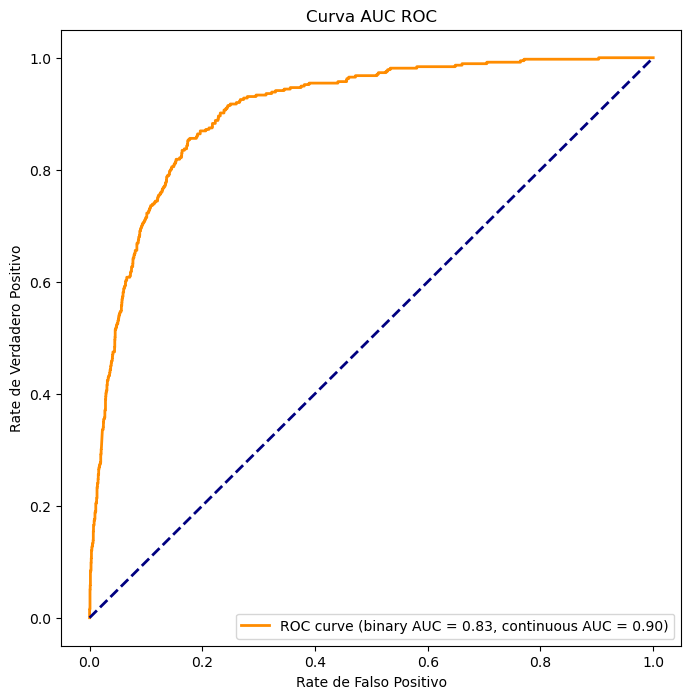

In [24]:
ypred_svc_cv_proba = svc_cv.predict_proba(pd.DataFrame(xtest_scal))[:, 1]
svc_roc_auc_cont = roc_auc_score(ytest, ypred_svc_cv_proba)

svc_cv_fpr,svc_cv_tpr, svc_cv_thresholds = roc_curve(ytest, ypred_svc_cv_proba)

plt.figure(figsize=(8, 8))
plt.plot(svc_cv_fpr, svc_cv_tpr, color='darkorange', lw=2, label='ROC curve (binary AUC = {:.2f}, continuous AUC = {:.2f})'.format(svc_max_roc_auc, svc_roc_auc_cont))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Rate de Falso Positivo')
plt.ylabel('Rate de Verdadero Positivo')
plt.title('Curva AUC ROC')
plt.legend(loc='lower right')
plt.show()

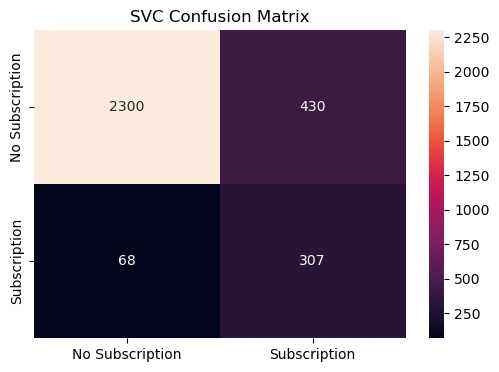

Sensitivity: 0.8186666666666667
Specificity: 0.8424908424908425


In [25]:
svc_data = confusion(ytest, ypred_svc_cv, 'SVC')

Obtenemos un buen score en general, con un gran porcentaje de Falsos Negativos sobre el total de las subscripciones reales.

### Logistic Regression

In [ ]:
# Crear el modelo de Regresión Logística
lr = LogisticRegression(
    class_weight='balanced',
    max_iter=10000
    )

# Definir los parámetros a ajustar
parameters = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'penalty': ['l1', 'l2']
}

lr_cv = GridSearchCV(
    lr,
    param_grid = parameters,
    refit = True,
    cv = skf,
    verbose = 0,
    scoring = 'roc_auc',
    n_jobs = -1
)

lr_cv.fit(xtrain_scal, ytrain)

In [52]:
best_params = lr_cv.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}


In [27]:
ypred_lr_cv = lr_cv.predict(pd.DataFrame(xtest_scal))
lr_max_roc_auc = roc_auc_score(ytest, ypred_lr_cv)
print(f'El mejor AUC ROC Score es de : {lr_max_roc_auc}')

El mejor AUC ROC Score es de : 0.8261611721611721


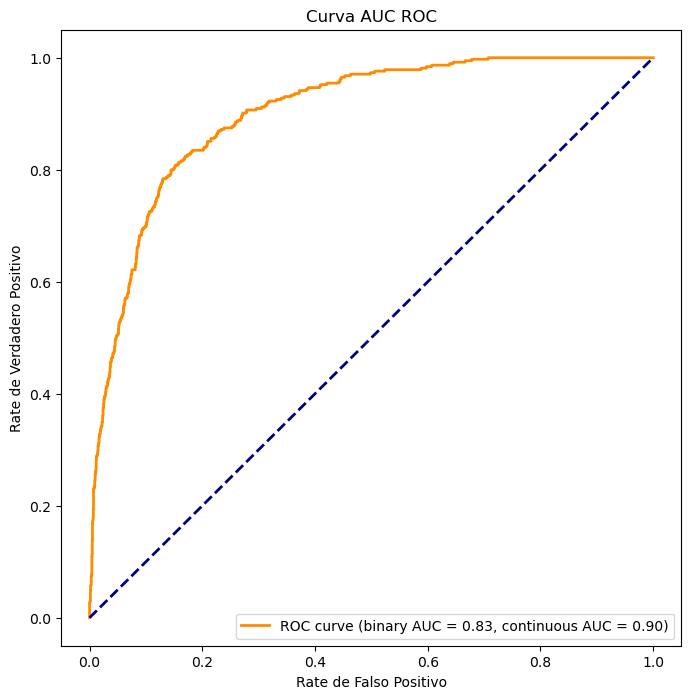

In [74]:
ypred_lr_proba = lr_cv.predict_proba(pd.DataFrame(xtest_scal))[:, 1]
lr_roc_auc_cont = roc_auc_score(ytest, ypred_lr_proba)

lr_fpr, lr_tpr, lr_thresholds = roc_curve(ytest, ypred_lr_proba)

plt.figure(figsize=(8, 8))
plt.plot(lr_fpr, lr_tpr, color='darkorange', lw=2, label='ROC curve (binary AUC = {:.2f}, continuous AUC = {:.2f})'.format(lr_max_roc_auc, lr_roc_auc_cont))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Rate de Falso Positivo')
plt.ylabel('Rate de Verdadero Positivo')
plt.title('Curva AUC ROC')
plt.legend(loc='lower right')
plt.show()

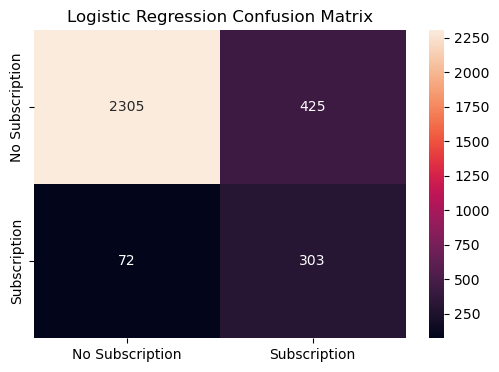

Sensitivity: 0.808
Specificity: 0.8443223443223443


In [29]:
lr_data = confusion(ytest,ypred_lr_cv,'Logistic Regression')

### Comparación de los modelos y elección

Veamos datos de los modelos lado a lado, para hacer la elección final

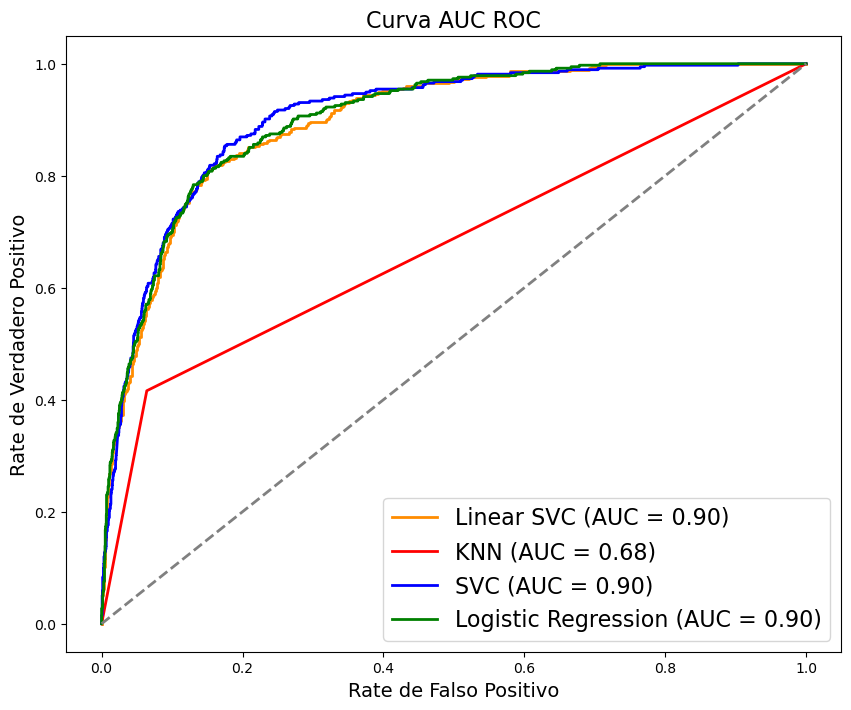

In [30]:
plt.figure(figsize=(10, 8))

# Linear SVC
plt.plot(linsvc_fpr, linsvc_tpr, color='darkorange', lw=2, label='Linear SVC (AUC = {:.2f})'.format(lin_roc_auc_cont))
# KNN
plt.plot(knn_fpr, knn_tpr, color='red', lw=2, label='KNN (AUC = {:.2f})'.format(knn_roc_auc_cont))
# SVC
plt.plot(svc_cv_fpr, svc_cv_tpr, color='blue', lw=2, label='SVC (AUC = {:.2f})'.format(svc_roc_auc_cont))
# Logistic Regression
plt.plot(lr_fpr, lr_tpr, color='green', lw=2, label='Logistic Regression (AUC = {:.2f})'.format(lr_roc_auc_cont))
# Línea diagonal
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Etiquetas y títulos con tamaños de fuente ajustados
plt.xlabel('Rate de Falso Positivo', fontsize=14)
plt.ylabel('Rate de Verdadero Positivo', fontsize=14)
plt.title('Curva AUC ROC', fontsize=16)
plt.legend(loc='lower right', fontsize=16)

# Mostramos el gráfico
plt.show()


Comparemos también las otras métricas

In [31]:
models_data = pd.DataFrame([lr_data, svc_data, knn_data, linear_svr_data], columns=["Model Name", "Specificity", "Sensitivity"]).set_index("Model Name").round(2)

In [32]:
models_data.head()

,Specificity,Sensitivity
Model Name,,
Logistic Regression,0.81,0.84
SVC,0.82,0.84
KNN,0.42,0.94
Linear SVR,0.82,0.84


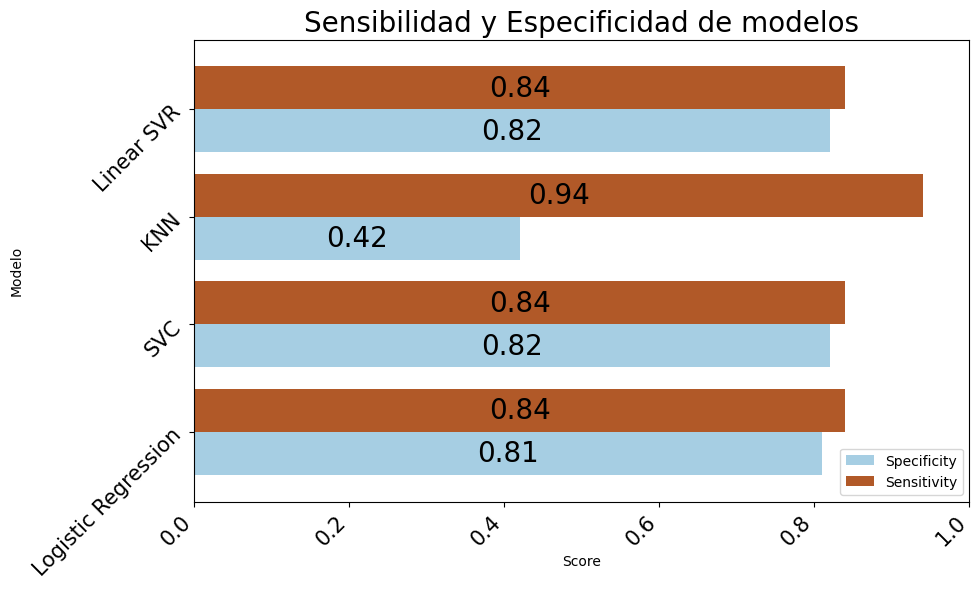

In [33]:
# Armamos el plot de barras horizontales
ax = models_data.plot(kind="barh", figsize=(10, 6), colormap="Paired", width=0.8)

# Etiquetas y titulos
plt.title('Sensibilidad y Especificidad de modelos',fontsize=20)
plt.xlabel('Score')  # Cambiamos ylabel por xlabel
plt.ylabel('Modelo')  # Cambiamos xlabel por ylabel y agregamos rotation
plt.xlim(0, 1)  # Delimitamos el eje

# Centramos las etiquetas de las barras
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='center', fontsize=20)
ax.bar_label(ax.containers[1], fmt='%.2f', label_type='center', fontsize=20)

# Rotamos las etiquetas del eje X en diagonal
plt.xticks(rotation=45, ha='right', fontsize=15)
# Rotamos las etiquetas del eje X en diagonal
plt.yticks(rotation=45, ha='right', fontsize=15)


# Mostramos el gráfico
plt.show()


Consideramos al modelo de SVC no lineal como el mejor de los 4 clasificadores, al tener una mejor curva AUC ROC y la mejor sensibilidad y especificidad

## PCA

In [34]:
# Cantidad de componentes a extraer
n_comps = 30
# Definimos PCA
pca = PCA(n_components= n_comps)
# Reducimos la dimensionalidad de los datos
xpca = pd.DataFrame(pca.fit_transform(xtrain_scal))
xpca_test = pd.DataFrame(pca.fit_transform(xtest_scal))
# Obtenemos los auto-valores
eigenvalues = pca.explained_variance_ratio_

In [35]:
# Observamos el shape de la matriz obtenida del PCA. Se ve que nuestro dataset se redujo de 49 a 10 dimensiones
xpca.shape

(12416, 30)

<Axes: >

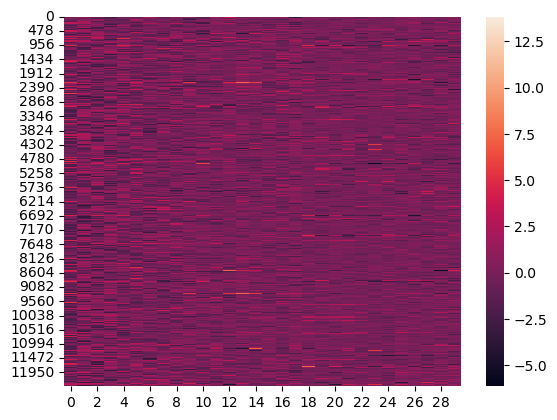

In [36]:
sns.heatmap(xpca)

No parece haber unas pocas columnas que expliquen la variablidad del modelo

Veamos como se ven los 3 principales componentes

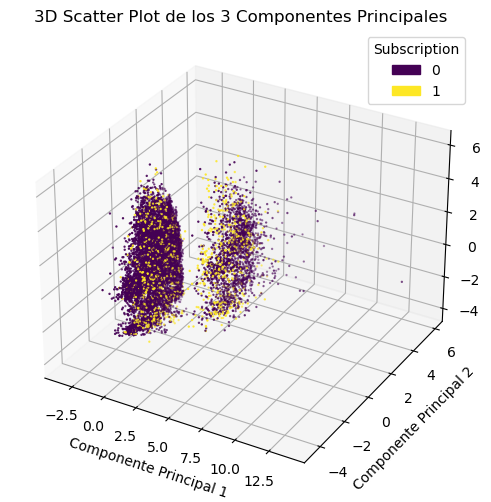

In [37]:
# Crear el gráfico
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot con color
scatter = ax.scatter(xpca[0], xpca[1], xpca[2], c=ytrain, cmap='viridis', marker='o', s=0.5)

# Crear leyenda
legend_labels = np.unique(ytrain)
legend_patches = [mpatches.Patch(color=scatter.cmap(scatter.norm(label)), label=f'{label}') for label in legend_labels]

# Agregar leyenda
ax.legend(handles=legend_patches, title='Subscription', loc='upper right')

# Etiquetas y título
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.set_title('3D Scatter Plot de los 3 Componentes Principales')

# Mostrar el gráfico
plt.show()

Y ahora la varianza de los datos

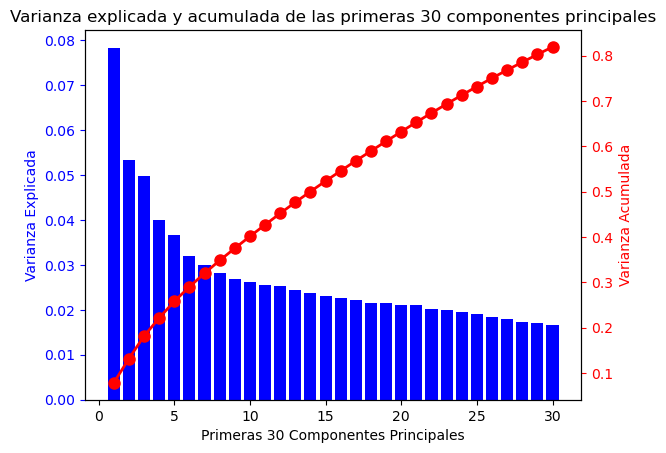

In [38]:
# Calcula la varianza acumulada
cumulative_variance = np.cumsum(eigenvalues)

# Números de componentes
components = range(1, n_comps + 1)

# Gráfico de barras para la varianza explicada por cada componente
fig, ax1 = plt.subplots()

ax1.bar(components, eigenvalues, color='blue')
ax1.set_xlabel('Primeras ' + str(n_comps) + ' Componentes Principales')
ax1.set_ylabel('Varianza Explicada', color='blue')
ax1.tick_params('y', colors='blue')

# Crea un segundo eje y para la varianza acumulada
ax2 = ax1.twinx()
ax2.plot(components, cumulative_variance, color='red', marker='o', linestyle='-', linewidth=2, markersize=8, label='Varianza Acumulada')
ax2.set_ylabel('Varianza Acumulada', color='red')
ax2.tick_params('y', colors='red')

# Títulos
plt.title('Varianza explicada y acumulada de las primeras ' + str(n_comps) + ' componentes principales')

# Mostrar el gráfico
plt.show()

Con el gráfico ya nos dabamos una idea de que la reducción de la dimensionalidad no funciona muy bien con este dataset. La varianza explicada termina de confirmar que si bien tiene 5 variables que explican la varianza mas que las otras, realmente no es suficiente para poder diferenciar las clases.

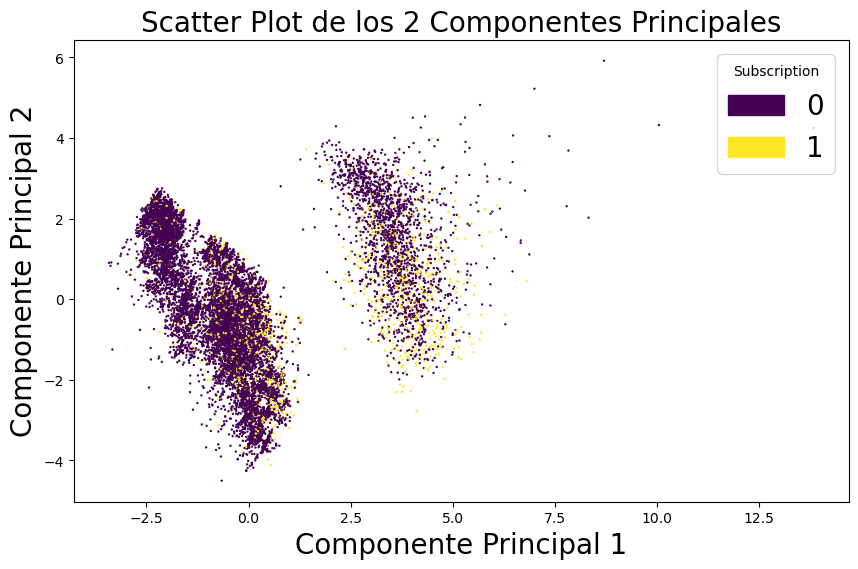

In [39]:
# Crear el gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot con color
scatter = ax.scatter(xpca[0], xpca[1], c=ytrain, cmap='viridis', s=0.5)

# Crear leyenda
legend_labels = np.unique(ytrain)
legend_patches = [mpatches.Patch(color=scatter.cmap(scatter.norm(label)), label=f'{label}') for label in legend_labels]

# Agregar leyenda
ax.legend(handles=legend_patches, title='Subscription', loc='upper right',fontsize=20)

# Etiquetas y título
ax.set_xlabel('Componente Principal 1',fontsize=20)
ax.set_ylabel('Componente Principal 2',fontsize=20)
ax.set_title('Scatter Plot de los 2 Componentes Principales',fontsize=20)

# Mostrar el gráfico
plt.show()

Se pueden reconocer dos clusters, pero ninguno es de una clase determinada.

Probemos primero alimentar al modelo con las 30 nuevas variables, y veamos los resultados

### SVC post reducción de dimensionalidad

In [ ]:
svc_pca = svm.SVC(
    class_weight='balanced',
    probability=True,
    max_iter=10000
    )

parameters = {
    'gamma': [0.01, 0.1, 1, 10],
    'C': [0.1, 1, 10],
    'kernel' : ['rbf','linear']
    }

svc_pca_cv = GridSearchCV(
    svc_pca,
    param_grid = parameters,
    refit = True,
    cv = skf,
    verbose = 0,
    scoring = 'roc_auc',
    n_jobs = -1
)

svc_pca_cv.fit(xpca, ytrain)

In [53]:
best_params = svc_pca_cv.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


In [41]:
ypred_svc_pca = svc_pca_cv.predict(xpca_test)
svc_pca_max_roc_auc = roc_auc_score(ytest, ypred_svc_pca)
print(f'El mejor AUC ROC Score es de : {svc_pca_max_roc_auc}')

El mejor AUC ROC Score es de : 0.6192161172161172


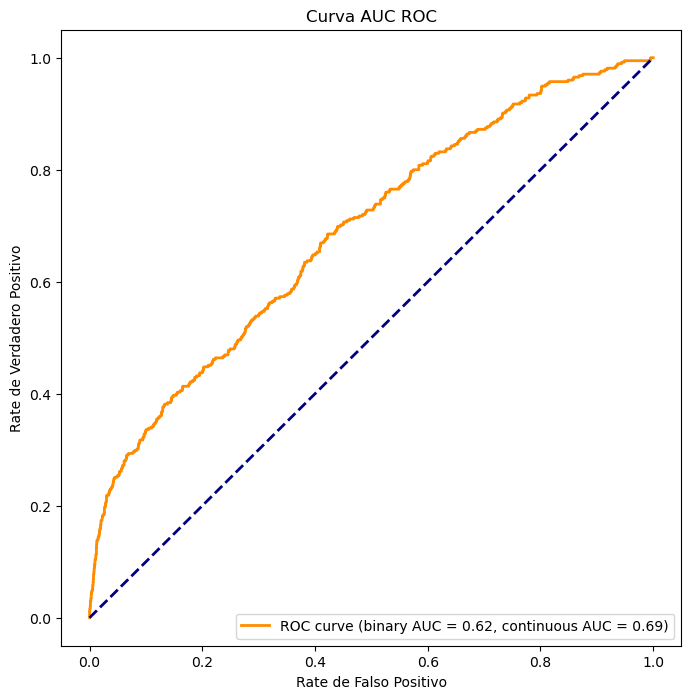

In [42]:
ypred_svc_pca_proba = svc_pca_cv.predict_proba(xpca_test)[:, 1]
svc_pca_roc_auc_cont = roc_auc_score(ytest, ypred_svc_pca_proba)

svc_pca_fpr,svc_pca_tpr, svc_pca_thresholds = roc_curve(ytest, ypred_svc_pca_proba)

plt.figure(figsize=(8, 8))
plt.plot(svc_pca_fpr, svc_pca_tpr, color='darkorange', lw=2, label='ROC curve (binary AUC = {:.2f}, continuous AUC = {:.2f})'.format(svc_pca_max_roc_auc, svc_pca_roc_auc_cont))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Rate de Falso Positivo')
plt.ylabel('Rate de Verdadero Positivo')
plt.title('Curva AUC ROC')
plt.legend(loc='lower right')
plt.show()

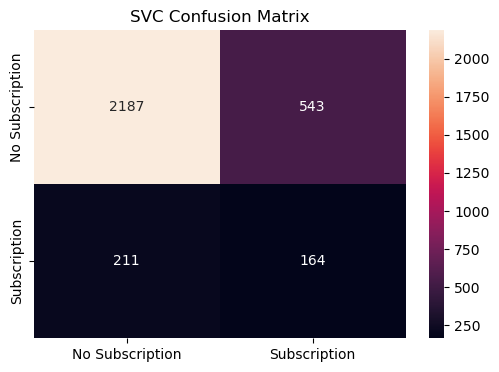

Sensitivity: 0.43733333333333335
Specificity: 0.8010989010989011


In [43]:
svc_pca_data = confusion(ytest, ypred_svc_pca, 'SVC')

Los resultados no son muy buenos. Que pasará entonces si en vez de utilizar las 30 columnas, tomamos solo las primeras 5 que presentaban más variabilidad?

In [44]:
xpca_top5 = xpca.iloc[:, :5]
xpca_test_top5 = xpca_test.iloc[:, :5]

In [ ]:
svc_pca5_cv = GridSearchCV(
    svc_pca,
    param_grid = parameters,
    refit = True,
    cv = skf,
    verbose = 0,
    scoring = 'roc_auc',
    n_jobs = -1
)

svc_pca5_cv.fit(xpca_top5, ytrain)

In [54]:
best_params = svc_pca5_cv.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [46]:
ypred_svc_pca5 = svc_pca5_cv.predict(xpca_test_top5)
svc_pca5_max_roc_auc = roc_auc_score(ytest, ypred_svc_pca5)
print(f'El mejor AUC ROC Score es de : {svc_pca5_max_roc_auc}')

El mejor AUC ROC Score es de : 0.72203663003663


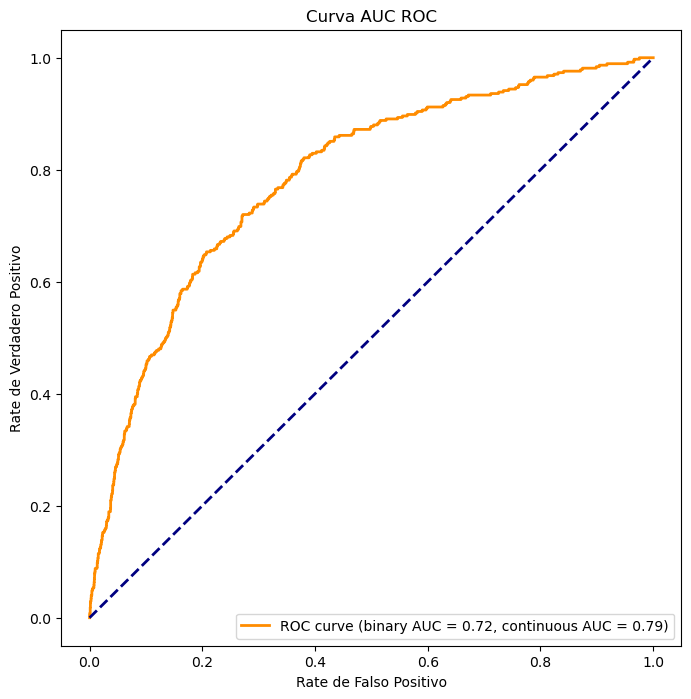

In [47]:
ypred_svc_pca5_proba = svc_pca5_cv.predict_proba(xpca_test_top5)[:, 1]
svc_pca5_roc_auc_cont = roc_auc_score(ytest, ypred_svc_pca5_proba)

svc_pca5_fpr,svc_pca5_tpr, svc_pca5_thresholds = roc_curve(ytest, ypred_svc_pca5_proba)

plt.figure(figsize=(8, 8))
plt.plot(svc_pca5_fpr, svc_pca5_tpr, color='darkorange', lw=2, label='ROC curve (binary AUC = {:.2f}, continuous AUC = {:.2f})'.format(svc_pca5_max_roc_auc, svc_pca5_roc_auc_cont))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Rate de Falso Positivo')
plt.ylabel('Rate de Verdadero Positivo')
plt.title('Curva AUC ROC')
plt.legend(loc='lower right')
plt.show()

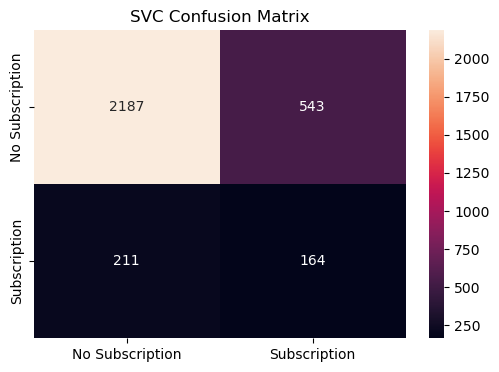

Sensitivity: 0.43733333333333335
Specificity: 0.8010989010989011


In [48]:
svc_pca5_data = confusion(ytest, ypred_svc_pca, 'SVC')

La curva es mejor que la anterior, pero con la información que tenemos podemos concluir que la reducción de dimensionalidad no beneficia al modelo.

Veamos el score dependiendo de cuantas componentes se alimentan al modelo

In [ ]:
score_pca_loop = pd.DataFrame(columns=['Componentes', 'Score'])
componentes = []
score = []

svc_loop = svm.SVC(
    kernel='rbf',
    gamma=0.01,
    C=10,
    class_weight='balanced',
    probability=True,
    max_iter=10000
    )

for i in range (1,31):
    xpca_loop = xpca.iloc[:, :(0+i)]
    xpca_test_loop = xpca_test.iloc[:, :(0+i)]

    svc_loop.fit(xpca_loop, ytrain)

    ypred_svc_pca_loop = svc_loop.predict(xpca_test_loop)
    svc_pca_loop_max_roc_auc = roc_auc_score(ytest, ypred_svc_pca_loop)

    componentes.append(i)
    score.append(svc_pca_loop_max_roc_auc)

In [50]:
score_pca_loop['Componentes'] = componentes
score_pca_loop['Score'] = score

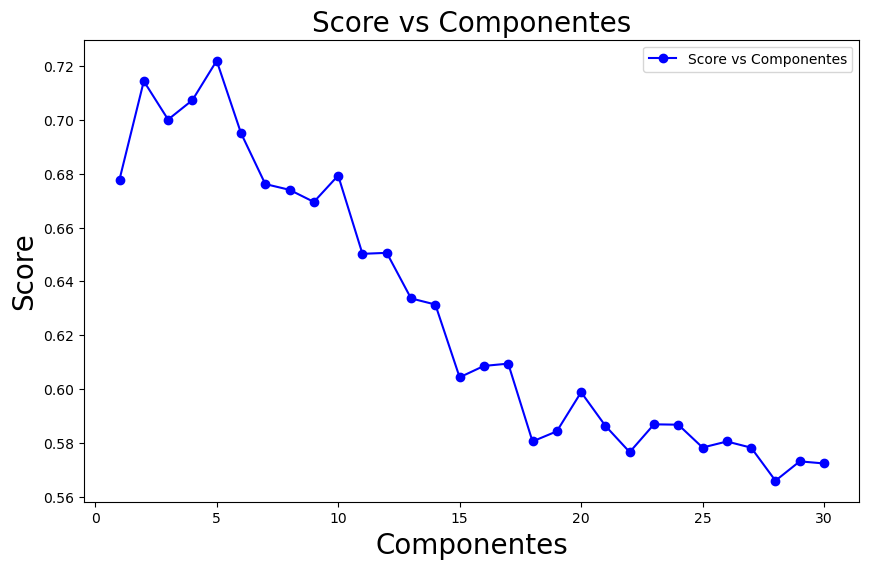

In [51]:
# Crear un gráfico de línea
plt.figure(figsize=(10, 6))
plt.plot(score_pca_loop['Componentes'], score_pca_loop['Score'], marker='o', linestyle='-', color='b', label='Score vs Componentes')

# Etiquetas y título con tamaño 20
plt.xlabel('Componentes', fontsize=20)
plt.ylabel('Score', fontsize=20)
plt.title('Score vs Componentes', fontsize=20)

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()